<a href="https://colab.research.google.com/github/mohsenmolaei/seriesnet_based/blob/main/seriesNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pdb
import pandas as pd 
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder ,StandardScaler
from sklearn.feature_selection import mutual_info_classif
# !pip install yfinance
# import yfinance as yf

from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/Colab Notebooks/tripple stage seriesnet"
import TSASeriesNet
if torch.cuda.is_available():
    # dev = "TPU:0"
    dev = "cuda:0" 
else: 
    dev = "cpu" 
device = torch.device(dev) 
print(device)

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/15DygMAXOJIypb4JGFSiPmdC6GqJjdD9a/tripple stage seriesnet
cuda:0


In [6]:
data= pd.read_csv('data.csv')
data.set_index("time_stamp",inplace=True,drop=True)
data
label_encoder = LabelEncoder()
n_bins = 50
data['difficulty_latest'] = data['difficulty_latest'].astype(float)
data['hash_rate_mean'] = data['hash_rate_mean'].astype(float)

data['difficulty_latest'] = label_encoder.fit_transform(pd.cut(data['difficulty_latest'] , n_bins, retbins=True)[0])
data['hash_rate_mean'] = label_encoder.fit_transform(pd.cut(data['hash_rate_mean'], n_bins, retbins=True)[0])

whatcol=[ 'price_drawdown_relative','difficulty_latest',
           'hash_rate_mean', 'active_more_1y_percent', 'utxo_created_value_median', 
           'transfers_volume_median', 'utxo_spent_value_median']

X, Y = data.drop(["price_usd_close"],axis =1), np.array(data.price_usd_close) #data[whatcol]

# print(X.shape)
# print(Y.shape)
# X

# label_encoder = LabelEncoder()
# n_bins = 16
# y_train = label_encoder.fit_transform(pd.cut(np.array(data.price_usd_close), n_bins, retbins=True)[0])

# mi= pd.DataFrame()
# mi = mutual_info_classif(data.drop(["price_usd_close"],axis =1), y_train) #, discrete_features=discrete_vars)
# mi = pd.Series(mi)
# mi

# y_train.shape

X.columns

Index(['price_drawdown_relative', 'block_count', 'block_interval_mean',
       'block_interval_median', 'block_size_mean', 'block_size_sum',
       'utxo_created_count', 'utxo_spent_count', 'utxo_created_value_sum',
       'utxo_spent_value_sum', 'utxo_created_value_mean',
       'utxo_spent_value_mean', 'utxo_created_value_median',
       'utxo_spent_value_median', 'address_count', 'sending_count',
       'receiving_count', 'active_count', 'new_non_zero_count', 'volume_sum',
       'volume_mean', 'volume_median', 'difficulty_latest', 'hash_rate_mean',
       'active_more_1y_percent', 'count', 'rate', 'size_mean',
       'transfers_volume_sum', 'transfers_volume_mean',
       'transfers_volume_median'],
      dtype='object')

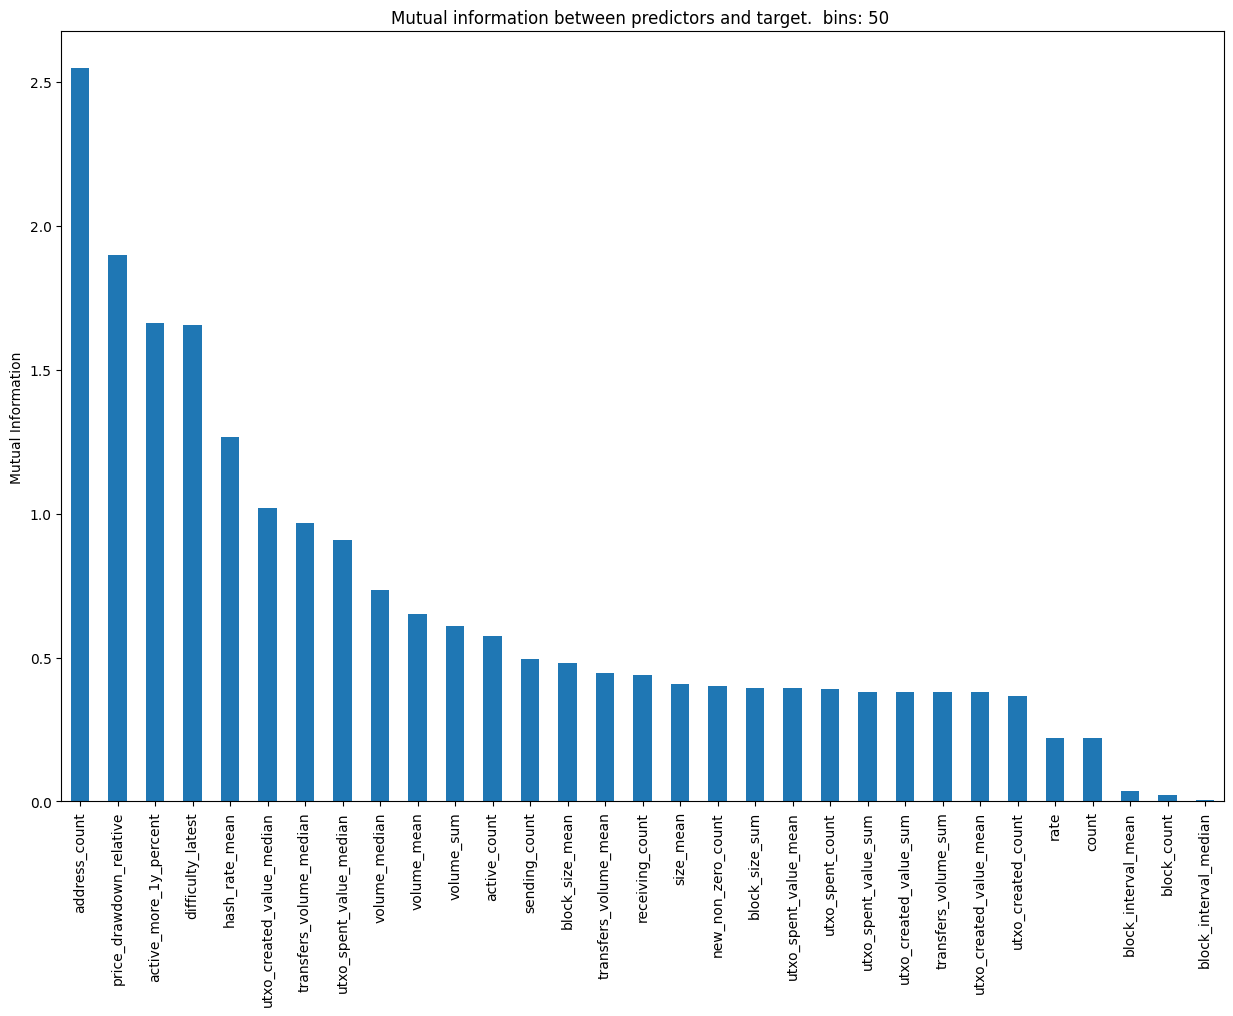

In [7]:

autoscaler = StandardScaler()
features = autoscaler.fit_transform(data)

label_encoder = LabelEncoder()
n_bins = 50
y_train = label_encoder.fit_transform(pd.cut(Y, n_bins, retbins=True)[0])

mi= pd.DataFrame()
mi = mutual_info_classif(X, y_train)#, discrete_features=discrete_vars)
mi
mi = pd.Series(mi)

mi.index = X.columns
mi.sort_values(ascending=False).plot.bar(figsize=(15, 10))
plt.ylabel('Mutual Information')
plt.title(f"Mutual information between predictors and target.  bins: {n_bins} ")

plt.show()

xindex = mi.sort_values(ascending=False)[0:8]
X = data[xindex.index]


In [8]:
# """ Condition_train """
# feature = ["CPI", "DXYN", "GBPUSD=X", "^TNX", "^DJI", "EURUSD=X", "SI=F", "^RUT", "CL=F", "^IXIC", "GC=F", "N225", "^FTSE"]
# start = "2016-1-1"
# end="2023-3-28"
# try : 
#     data_CPI = yf.download("CL=F CPI DXYN GC=F  SI=F ^DJI ^IXIC ^RUT ^TNX" ,start=start, end=end , interval ="1d") #1137
# except Exception as e: 
#     print("error")
# data_CPI.set_index(pd.to_datetime(data_CPI.index).date,inplace=True) 
# try : 
#     EURUSD = yf.download("EURUSD=X GBPUSD=X ^FTSE" ,start=start, end=end , interval ="1d") #1176 
# except Exception as e: 
#     print("error")
# EURUSD.set_index(pd.to_datetime(EURUSD.index).date,inplace=True) 
# try : 
#     N225 = yf.download("^N225" ,start=start, end=end , interval ="1d") #1095 
#     N225.rename(columns={'Close': 'N225'}, inplace=True)
# except Exception as e: 
#     print("error")
# N225.set_index(pd.to_datetime(N225.index).date,inplace=True) 

# merged_df = pd.merge(data_CPI.Close, EURUSD.Close , left_index=True, right_index=True, how='outer')
# merged_df.fillna(method='ffill', inplace=True) 
# Condition = pd.merge(merged_df, N225.N225 , left_index=True, right_index =True, how='outer')
# Condition.fillna(method='ffill', inplace=True) 

# try:
#     data_crypto = yf.download("BTC-USD" ,start=start, end=end , interval ="1d")
# except Exception as e: 
#     print("error")
# data_crypto.set_index(pd.to_datetime(data_crypto.index).date,inplace=True) 
# merged_df = pd.merge(data_crypto.Close, Condition , left_index=True, right_index=True, how='outer')
# merged_df.fillna(method='bfill', inplace=True)  
# # merged_df.fillna(method='', inplace=True)  

# ccol = ['CL=F', 'CPI', 'DXYN', 'GC=F', 'SI=F', '^DJI', '^IXIC', '^RUT', '^TNX','EURUSD=X', 'GBPUSD=X', '^FTSE', 'N225']
# Condition = merged_df[ccol]
# Condition
Condition= pd.read_csv('Condition.csv')
Condition.set_index("time_stamp",inplace=True,drop=True)
Condition
# pd.DataFrame(Condition).to_csv('Condition.csv', index=True) 

,CL=F,CPI,DXYN,GC=F,SI=F,^DJI,^IXIC,^RUT,^TNX,EURUSD=X,GBPUSD=X,^FTSE,N225
time_stamp,,,,,,,,,,,,,
2016-01-01,36.759998,26.530001,5.03,1075.099976,13.817000,17148.939453,4903.089844,1108.619995,2.245,1.085906,1.473839,6093.399902,18450.980469
2016-01-02,36.759998,26.530001,5.03,1075.099976,13.817000,17148.939453,4903.089844,1108.619995,2.245,1.085399,1.473709,6093.399902,18450.980469
2016-01-03,36.759998,26.530001,5.03,1075.099976,13.817000,17148.939453,4903.089844,1108.619995,2.245,1.085399,1.473709,6093.399902,18450.980469
2016-01-04,36.759998,26.530001,5.03,1075.099976,13.817000,17148.939453,4903.089844,1108.619995,2.245,1.085399,1.473709,6093.399902,18450.980469
2016-01-05,35.970001,26.420000,4.90,1078.400024,13.949000,17158.660156,4891.430176,1110.439941,2.248,1.082755,1.471410,6137.200195,18374.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-23,69.959999,24.860001,0.72,1993.800049,23.143999,32105.250000,11787.400391,1720.290039,3.406,1.087039,1.227973,7499.600098,27419.609375
2023-03-24,69.260002,24.900000,0.77,1982.099976,23.247000,32237.529297,11823.959961,1734.920044,3.380,1.083506,1.228154,7405.500000,27385.250000
2023-03-25,72.809998,24.910000,0.73,1952.400024,23.054001,32432.080078,11768.839844,1753.670044,3.528,1.077819,1.224600,7471.799805,27476.869141


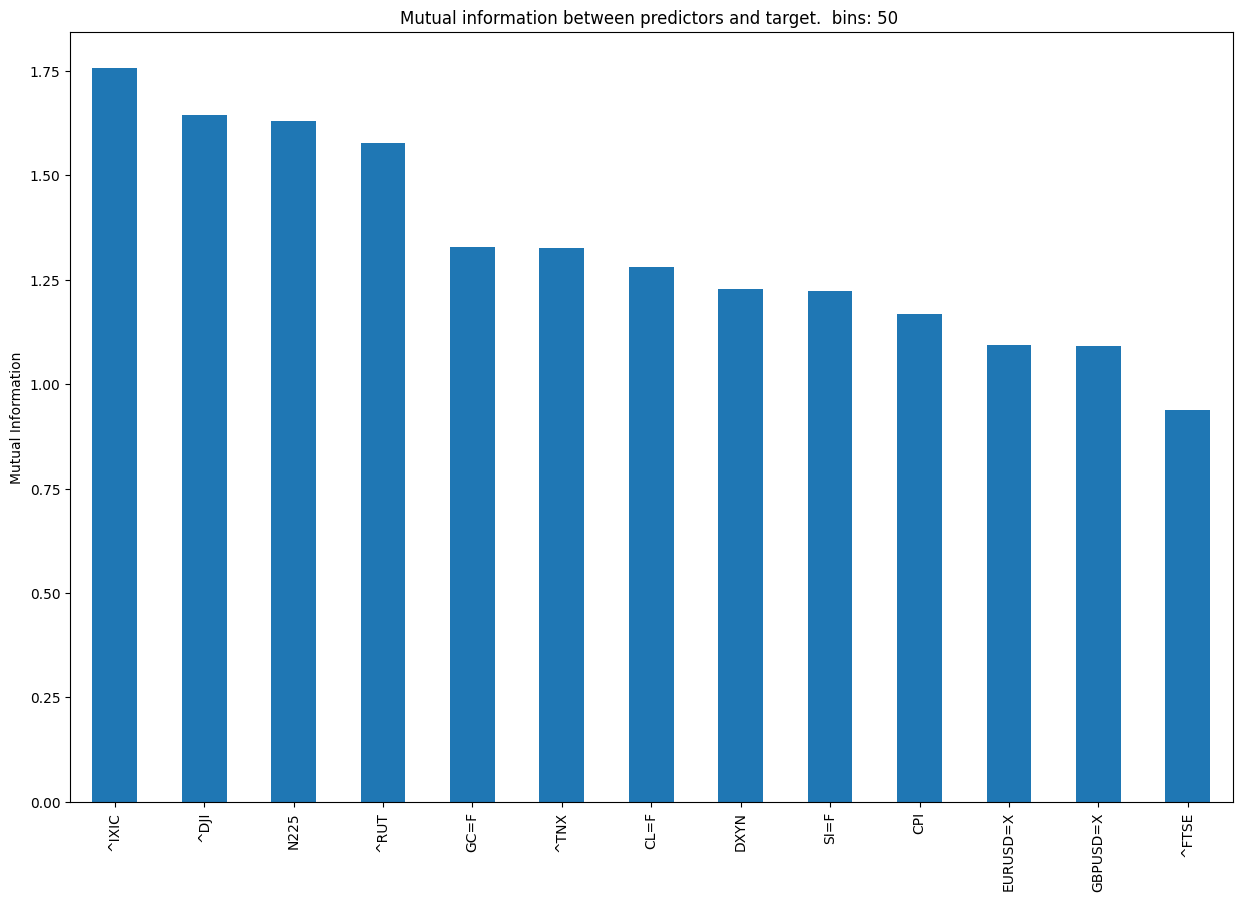

In [9]:
autoscaler = StandardScaler()
features = autoscaler.fit_transform(Condition)

label_encoder = LabelEncoder()
n_bins = 50
y_train = label_encoder.fit_transform(pd.cut(Y, n_bins, retbins=True)[0])

mi= pd.DataFrame()
mi = mutual_info_classif(Condition, y_train)#, discrete_features=discrete_vars)
mi
mi = pd.Series(mi)

mi.index = Condition.columns
mi.sort_values(ascending=False).plot.bar(figsize=(15, 10))
plt.ylabel('Mutual Information')
plt.title(f"Mutual information between predictors and target.  bins: {n_bins} ")

plt.show()

# xindex = mi.sort_values(ascending=False)[0:8]
# Condition = data[xindex.index]


In [10]:
"""# scale features""" 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
MMScaler = MinMaxScaler()
SScaler = StandardScaler()
condscaler = StandardScaler()

X_trans = SScaler.fit_transform(X)
c_trans = condscaler.fit_transform(Condition)
y_trans = MMScaler.fit_transform(Y.reshape(-1, 1))
print(X_trans.shape)
print(c_trans.shape)
print(y_trans.shape)


"""# split a multivariate sequence past, future samples (X and y)"""
def split_sequences(input_sequences, condition_seq, output_sequence, n_steps_in, n_steps_out):
    X, C, y = list(),list(), list() 
    for i in range(len(input_sequences)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out 
        if out_end_ix >= len(input_sequences): break
        seq_x, seq_c, seq_y = input_sequences[i:end_ix], condition_seq[i:end_ix], output_sequence[end_ix:out_end_ix]
        X.append(seq_x), C.append(seq_c) ,y.append(seq_y)
    return np.array(X), np.array(C), np.array(y)

x_shape = 30
y_shape = 7
X_ss, C_ss, y_mm = split_sequences(X_trans, c_trans, y_trans, x_shape, y_shape)
print(X_ss.shape, C_ss.shape, y_mm.shape)

total_samples = len(X)
train_test_cutoff = round(0.80 * total_samples)

X_train = X_ss[:-(total_samples-train_test_cutoff)]
C_train = C_ss[:-(total_samples-train_test_cutoff)]
X_test = X_ss[-(total_samples-train_test_cutoff):]
C_test = C_ss[-(total_samples-train_test_cutoff):]

y_train = y_mm[:-(total_samples-train_test_cutoff)]
y_test = y_mm[-(total_samples-train_test_cutoff):] 

print(total_samples - train_test_cutoff)
print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape)

"""# convert to pytorch tensors"""
X_train_tensors = Variable(torch.Tensor(X_train).to(device))
X_test_tensors = Variable(torch.Tensor(X_test).to(device))

C_train_tensors = Variable(torch.Tensor(C_train).to(device))
C_test_tensors = Variable(torch.Tensor(C_test).to(device))

y_train_tensors = Variable(torch.Tensor(y_train).to(device))
y_test_tensors = Variable(torch.Tensor(y_test).to(device))

print(X_train_tensors.shape)
print(C_train_tensors.shape)

"""# reshaping to rows, timestamps, features"""

X_train_tensors_final = torch.reshape(X_train_tensors,   
                                      (X_train_tensors.shape[0], x_shape, 
                                       X_train_tensors.shape[2]))
X_test_tensors_final = torch.reshape(X_test_tensors,  
                                     (X_test_tensors.shape[0], x_shape, 
                                      X_test_tensors.shape[2])) 

C_train_tensors_final = torch.reshape(C_train_tensors,   
                                      (C_train_tensors.shape[0], x_shape, 
                                       C_train_tensors.shape[2]))
C_test_tensors_final = torch.reshape(C_test_tensors,  
                                     (C_test_tensors.shape[0], x_shape, 
                                      C_test_tensors.shape[2])) 

print("Training Shape:", X_train_tensors_final.shape, C_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, C_test_tensors_final.shape, y_test_tensors.shape)



(2643, 8)
(2643, 13)
(2643, 1)
(2606, 30, 8) (2606, 30, 13) (2606, 7, 1)
529
Training Shape: (2077, 30, 8) (2077, 7, 1)
Testing Shape: (529, 30, 8) (529, 7, 1)
torch.Size([2077, 30, 8])
torch.Size([2077, 30, 13])
Training Shape: torch.Size([2077, 30, 8]) torch.Size([2077, 30, 13]) torch.Size([2077, 7, 1])
Testing Shape: torch.Size([529, 30, 8]) torch.Size([529, 30, 13]) torch.Size([529, 7, 1])


In [11]:
# %%
def NRMSELoss(yhat,y): #NRMSE
  y = y.reshape(y.shape[0], y.shape[1])
  return (torch.sqrt(torch.mean(torch.square(yhat-y))))/ (torch.max(y) - torch.min(y))

# Root Mean Squared Percentage Error (RMSPE)
def rmspe(y_pred,y_true):
  y_true = y_true.reshape(y_true.shape[0], y_true.shape[1])
  return torch.sqrt(torch.mean(torch.square((y_true - y_pred) / y_true)))

def MAPELoss(yhat,y):
  y = y.reshape(y.shape[0], y.shape[1])
  return torch.mean(torch.abs(yhat-y)/torch.abs(y))

def SMAPELoss(y_pred, y_true):
  y_true = y_true.reshape(y_true.shape[0], y_true.shape[1])
  loss = 2 * torch.mean(torch.abs(y_true - y_pred) / (torch.max(y_true) + torch.max(y_true)))
  return loss

def MSELoss(y_pred, y_true):
  y_true = y_true.reshape(y_true.shape[0], y_true.shape[1])
  loss = torch.mean((y_pred - y_true)**2)
  return loss

In [12]:
# !pip install tensorboard
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('logs')


def exp_lr_scheduler(optimizer, epoch, init_lr=0.01, lr_decay_epoch=200):
    lr = init_lr * (0.9**(epoch // lr_decay_epoch))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer

def training_loop(n_epochs,learning_rate, lr_decay_epoch, network, optimiser, loss_fn, X_train, Condition_train, y_train,X_test, Condition_test, y_test):
    loss_valid_show,loss_train_show = [],[]

    if torch.cuda.is_available():
        network.cuda()
    # early_stop_counter = 0
    # patience = 50
    # best_test_loss = float('inf')
    for epoch in range(n_epochs):
        if (epoch % (lr_decay_epoch) == 0) and (epoch != 0):
            optimiser = exp_lr_scheduler(optimiser,epoch, init_lr= learning_rate , lr_decay_epoch= lr_decay_epoch)

        network.train()
        outputs = network.forward(X_train, Condition_train) # forward pass
        optimiser.zero_grad() # calculate the gradient, manually setting to 0
        # obtain the loss function
        
        # pdb.set_trace()
        loss = loss_fn(outputs, y_train)
        loss.backward() # calculates the loss of the loss function
        # print(optimiser.lr)

        optimiser.step() # improve from loss, i.e backprop
        # test loss
        network.eval()
        test_preds = network(X_test, Condition_test)
        test_loss = loss_fn(test_preds, y_test)

        loss_valid_show.append(test_loss.item())
        loss_train_show.append(loss.item())

        # writer.add_scalar('Accuracy/train', acc, epoch)
        writer.add_scalar('Loss/Validation', test_loss.item(), epoch)
        writer.add_scalar('Loss/Train', loss.item(), epoch)

        #  early stop
        # if test_loss.item() < best_test_loss :
        #     best_test_loss = test_loss.item()
        #     early_stop_counter = 0
        # elif test_loss.item() > best_test_loss and  test_loss.item() < 0.1:
        #     early_stop_counter += 1

        # if early_stop_counter >= patience:
        #     print("Early stopping at epoch %d" % epoch)
        #     print("Epoch: %4d, train loss: %1.5f, test loss: %1.5f" % (epoch, loss.item(),test_loss.item()))
        #     break

        if (epoch) % (50) == 0:
            print("Epoch: %4d, train loss: %1.5f, test loss: %1.5f" % (epoch, loss.item(),test_loss.item()))
    writer.close()
    return loss_train_show , loss_valid_show


In [ ]:
"""# Training"""

import torch
torch.cuda.empty_cache()
import gc
gc.collect()

40457

In [ ]:
# torch.manual_seed(17)
# torch.cuda.manual_seed(17)
# np.random.seed(17)
# torch.backends.cudnn.deterministic=True

import importlib
import Decoder_DARLM
import Encoder_DARLM
import LSTM_block
import GRU_block
import HSAM
import CBAM
importlib.reload(CBAM)
importlib.reload(Decoder_DARLM)
importlib.reload(TSASeriesNet)
importlib.reload(Encoder_DARLM)
importlib.reload(GRU_block)
importlib.reload(LSTM_block)
importlib.reload(HSAM)


n_epochs = 401
# num_inputs_c = X_train_tensors_final.shape[1] # number of condition's features 
num_inputs = X_train_tensors_final.shape[1] # number of condition's inputs
dilation_c = 2
kernel_size_EN = 3
kernel_size_DE = 3
hidden_size_lstm =10

num_levels_en = 6
num_levels_de = 4
num_layers_lstm = 6
num_layers_gru = 4
features = X_train_tensors_final.shape[2]   # number of condition's timeseries 
features_c = C_train_tensors_final.shape[2]   # number of condition's inputs 
# features = C_train_tensors_final.shape[2]   # number of condition's timeseries 
# features_c = X_train_tensors_final.shape[2]   # number of condition's inputs 
output_num = y_train_tensors.shape[1]

lr_decay_epoch = 49
learning_rate = 0.01
weight_decay = 0.0001

# import torchmetrics
loss_fn = NRMSELoss #SMAPELoss #MAPELoss #NRMSELoss #rmspe
# ANN model 
myModel = TSASeriesNet.ANNmodel(num_inputs, features_c, features, output_num, num_levels_en,num_levels_de, kernel_size_EN, kernel_size_DE, dilation_c, hidden_size_lstm, num_layers_lstm, num_layers_gru ).to(device)
# loss_fn = nn.torch.   #torch.nn.MSE  mean-squared error for regression =============> MAE?
optimiser = torch.optim.Adam(myModel.parameters(),weight_decay=weight_decay)#,eps=1e-08)#, lr=learning_rate)#, eps=1e-08)#

loss_train_show ,loss_valid_show = training_loop(n_epochs=n_epochs,
                                  learning_rate = learning_rate,
                                  lr_decay_epoch = lr_decay_epoch,
                                  network=myModel,
                                  optimiser=optimiser,
                                  loss_fn=loss_fn,
                                  X_train=X_train_tensors_final,
                                  Condition_train = C_train_tensors_final,
                                  y_train=y_train_tensors,
                                  X_test=X_test_tensors_final,
                                  Condition_test  = C_test_tensors_final,
                                  y_test=y_test_tensors)

# loss_train_show ,loss_valid_show = training_loop(n_epochs=n_epochs,
#                                   learning_rate = learning_rate,
#                                   lr_decay_epoch = lr_decay_epoch,
#                                   network=myModel,
#                                   optimiser=optimiser,
#                                   loss_fn=loss_fn,
#                                   X_train=C_train_tensors_final,
#                                   Condition_train =X_train_tensors_final ,
#                                   y_train=y_train_tensors,
#                                   X_test=C_test_tensors_final,
#                                   Condition_test  = X_test_tensors_final,
#                                   y_test=y_test_tensors)

In [ ]:
predict = myModel(X_test_tensors_final,C_test_tensors_final)
predict = predict.detach().cpu().numpy()
predict = MMScaler.inverse_transform(predict)

true = np.squeeze(y_test)
true = MMScaler.inverse_transform(true)

# assume predict and true are matrices of daily prices with shape (num_samples, num_days)
# assume you want to invest $1000 on each trading day
# initial_capital = 1000

# calculate the daily returns based on the predicted and true prices
predict_returns = (predict[:, 1:] - predict[:, :-1]) / predict[:, :-1]
true_returns = (true[:, 1:] - true[:, :-1]) / true[:, :-1]

# calculate the position you would have taken based on your prediction
predict_position = np.where(predict_returns > 0.0, 1, -1)
true_position = np.where(true_returns > 0.0, 1, -1)

# define a function to simulate the portfolio based on the predicted or true returns
def simulate_portfolio(position, returns, initial_capital):
    # calculate the daily profit and loss based on the position you took and the daily returns
    pnl = position * initial_capital * returns

    # calculate the cumulative PnL over the entire period
    cumulative_pnl = np.cumsum(pnl)

    # calculate the final portfolio value
    final_value = initial_capital + cumulative_pnl[-1]

    # calculate the profit percentage
    profit_percentage = ((final_value - initial_capital) / initial_capital) * 100

    return final_value, profit_percentage

# simulate the portfolio based on the predicted and true returns for different initial capital values
for cap in [1000, 2000, 5000, 10000]:
    print(f"\nFor initial capital of {cap}:")
    predict_final_value, predict_profit_percentage = simulate_portfolio(predict_position, predict_returns, cap)
    true_final_value, true_profit_percentage = simulate_portfolio(true_position, true_returns, cap)
    print(f"Predicted final value   : {predict_final_value:.2f} with {predict_profit_percentage:.2f}% profit")
    print(f"True final value        : {true_final_value:.2f} with {true_profit_percentage:.2f}% profit")
    print(f"(Predicted/True)% profit: {predict_final_value*100/true_final_value:.2f}% profit") 
    print("-----------------------------------------------------------")

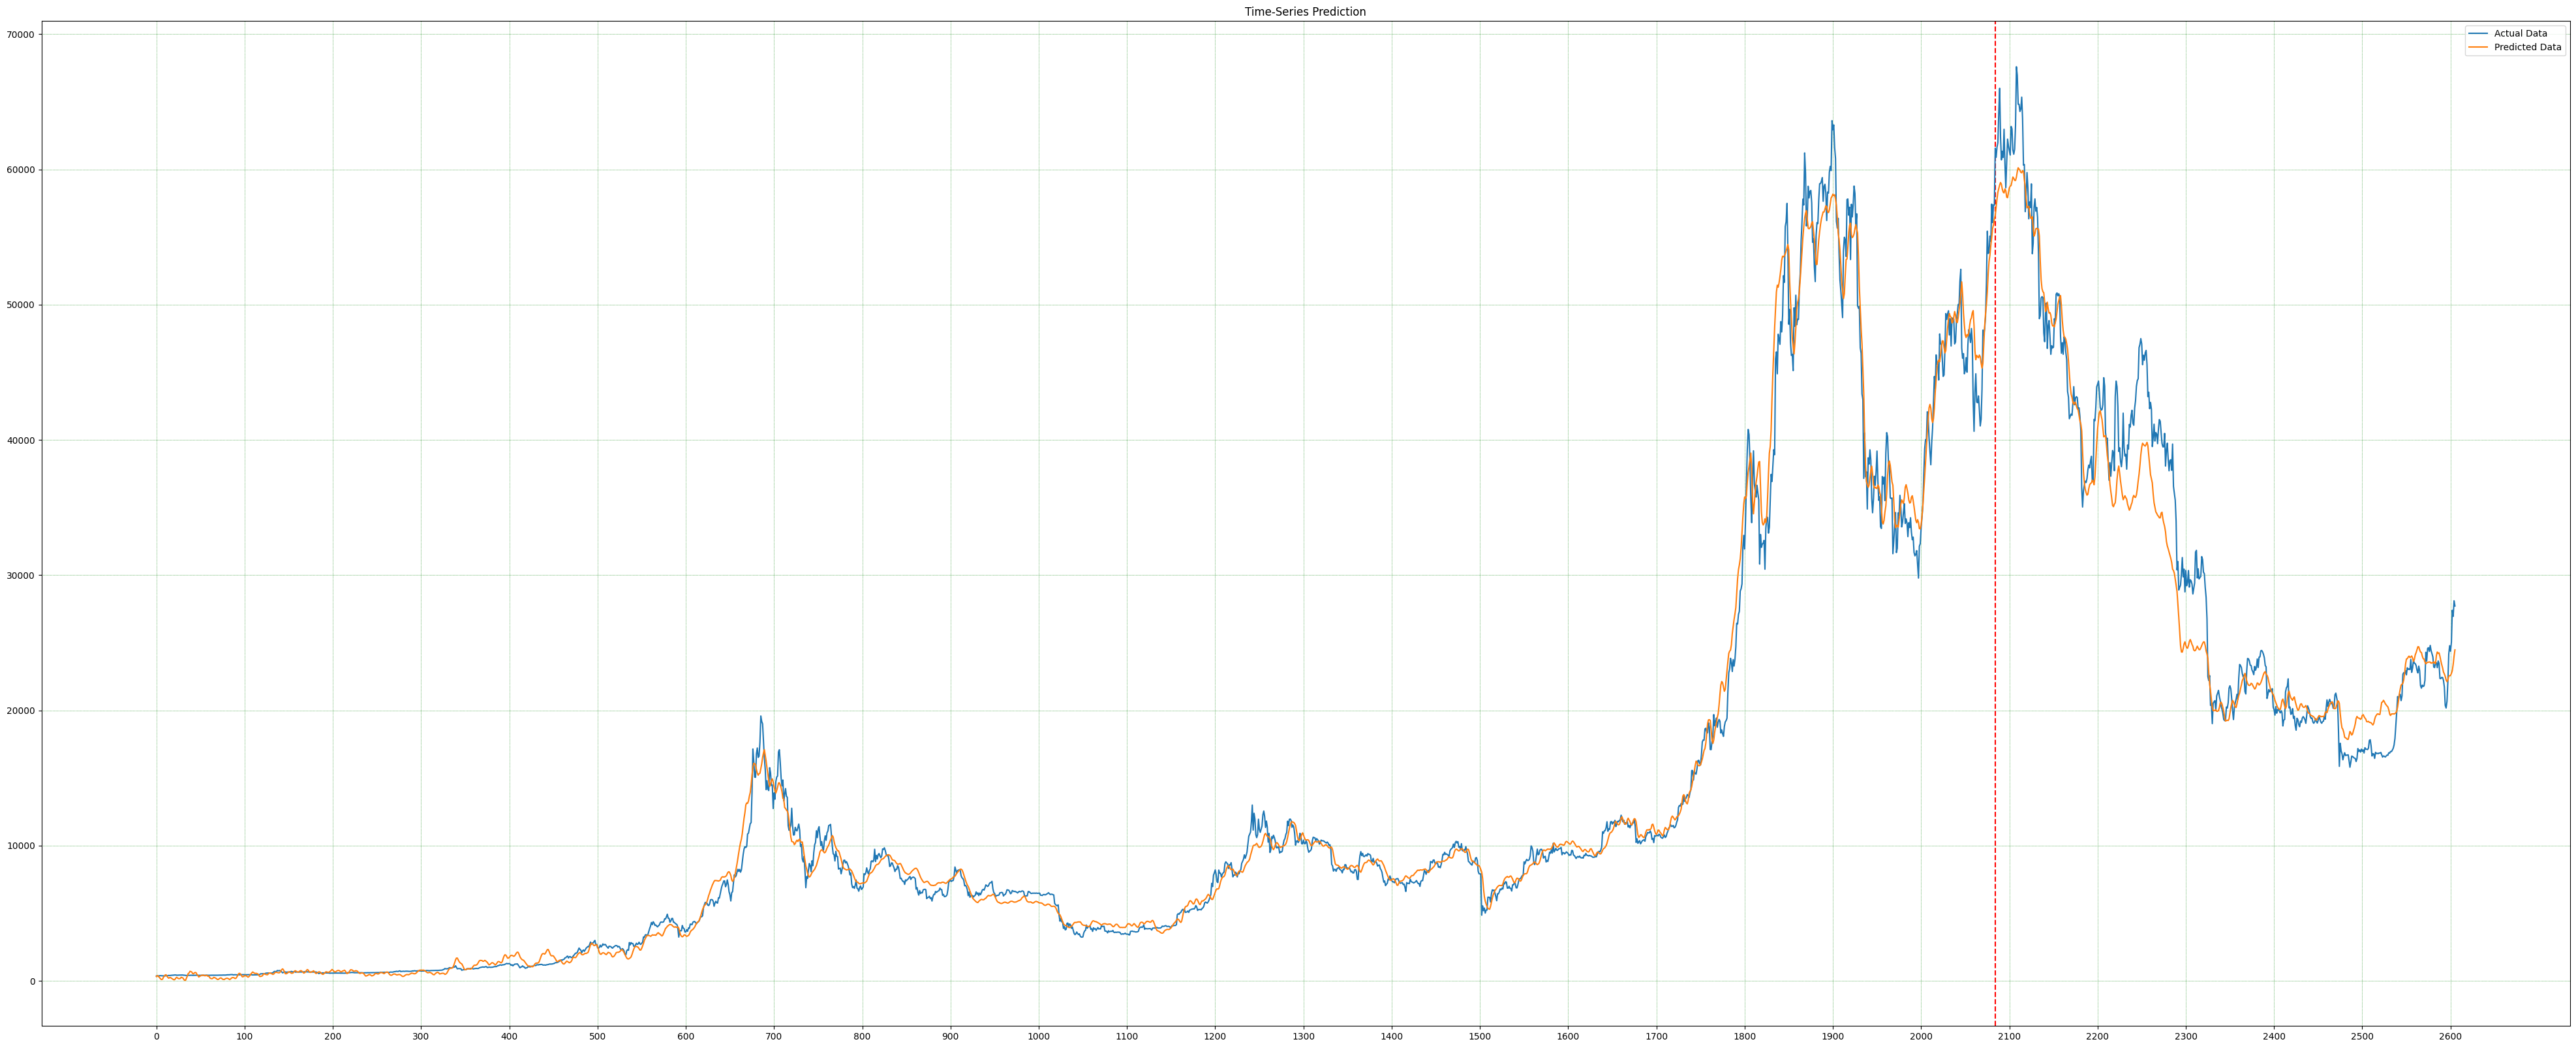

In [91]:
ccol = ['CL=F', 'CPI', 'DXYN', 'GC=F', 'SI=F', '^DJI', '^IXIC', '^RUT', '^TNX','EURUSD=X', 'GBPUSD=X', '^FTSE', 'N225']

df_X_ss = SScaler.transform(X) # old transformers
df_C_ss = condscaler.transform(Condition[ccol])

df_y_mm = MMScaler.transform(np.array(data.price_usd_close).reshape(-1, 1))
df_y_mm = df_y_mm.squeeze()
# split the sequence
df_X_ss, df_C_ss, df_y_mm = split_sequences(df_X_ss, df_C_ss, df_y_mm, x_shape, y_shape)
# converting to tensors
df_X_ss = Variable(torch.Tensor(df_X_ss)) 
df_C_ss = Variable(torch.Tensor(df_C_ss))
df_y_mm = Variable(torch.Tensor(df_y_mm))
# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], x_shape, df_X_ss.shape[2]))
df_C_ss = torch.reshape(df_C_ss, (df_C_ss.shape[0], x_shape, df_C_ss.shape[2]))

train_predict = myModel(df_X_ss.to(device),df_C_ss.to(device)).cpu() # forward pass
# train_predict = myModel(df_C_ss.to(device),df_X_ss.to(device)).cpu() # forward pass

data_predict = train_predict.data.numpy() # numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = MMScaler.inverse_transform(data_predict) # reverse transformation
dataY_plot = dataY_plot.squeeze()
dataY_plot = MMScaler.inverse_transform(dataY_plot)
true, preds = [], []
for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])


plt.figure(figsize=(50,20)) #plotting
plt.axvline(x=train_test_cutoff -(x_shape), c='r', linestyle='--') # size of the training set

plt.xticks(range(0,total_samples,100))
plt.grid(color='g', linestyle=':', linewidth=0.5)
plt.plot(true, label='Actual Data') # actual plot
plt.plot(preds, label='Predicted Data') # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
# plt.savefig("whole_plot.png", dpi=300)
plt.show()

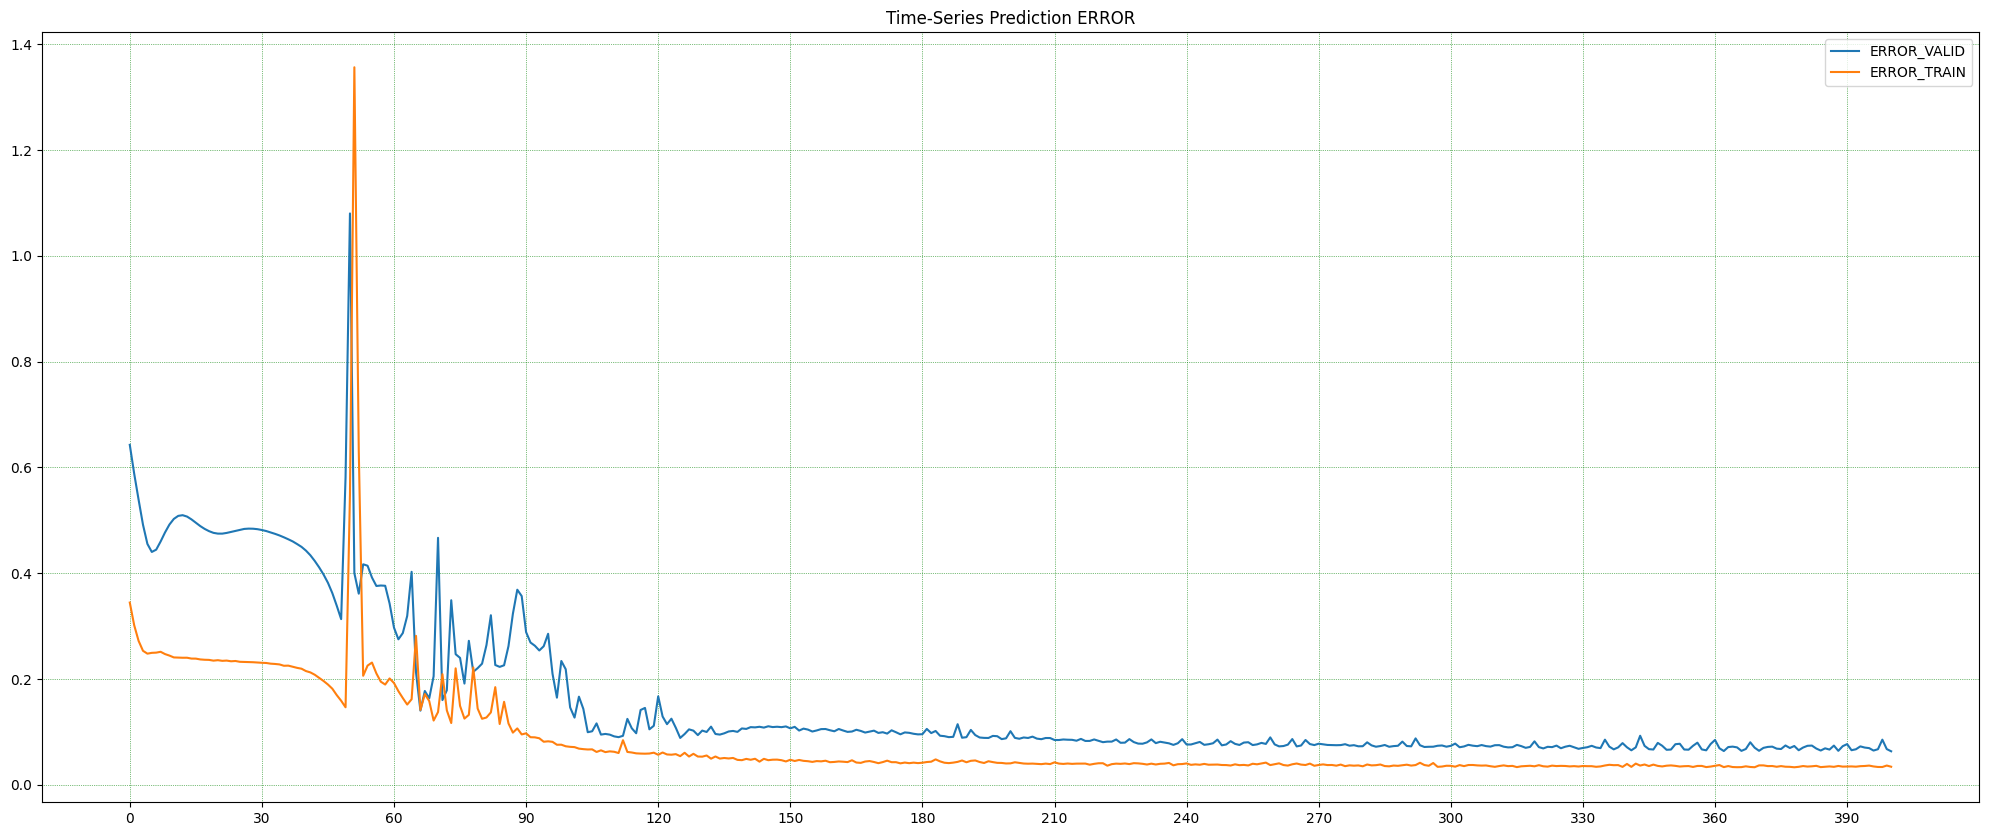

In [89]:
plt.figure(figsize=(25,10)) #plotting
plt.plot(loss_valid_show, label='ERROR_VALID') 
plt.plot(loss_train_show, label='ERROR_TRAIN') 
plt.title('Time-Series Prediction ERROR')
plt.grid(color='g', linestyle=':', linewidth=0.5)
plt.xticks(range(0,n_epochs+1,30))
plt.legend()
plt.show()
# print(loss_show)


In [ ]:
myModel
# Print initial weights
print("Initial weights:")
for name, param in myModel.named_parameters():
    if 'weight' in name:
        print(name, param.data)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

# %load_ext tensorboard
# %tensorboard --logdir /content/drive/MyDrive/logs

In [92]:
from sklearn.model_selection import ParameterGrid

# Define the hyperparameter grid
param_grid = {
    'kernel_size_EN': [3],
    'kernel_size_DE': [3],
    'hidden_size_lstm': [10],
    'num_levels_en': [2,4,6],
    'num_levels_de': [2,4,6],
    'num_layers_lstm': [2,6],
    'num_layers_gru': [2,4]
}
loss_fn = NRMSELoss
# lr_decay_epoch = 49
# learning_rate = 0.01
# weight_decay = 0.001

def run_experiment(params):
    myModel = TSASeriesNet.ANNmodel(X_train_tensors_final.shape[1], C_train_tensors_final.shape[2], X_train_tensors_final.shape[2],y_train_tensors.shape[1],
                                    params['num_levels_en'], params['num_levels_de'], params['kernel_size_EN'],
                                    params['kernel_size_DE'], 2, params['hidden_size_lstm'],
                                    params['num_layers_lstm'], params['num_layers_gru']).to(device)

    optimiser = torch.optim.Adam(myModel.parameters(),weight_decay=0.0001)#, weight_decay=weight_decay, lr=learning_rate)

    loss_train_show, loss_valid_show = training_loop(n_epochs=401,
                                                      learning_rate=learning_rate,
                                                      lr_decay_epoch=lr_decay_epoch,
                                                      network=myModel,
                                                      optimiser=optimiser,
                                                      loss_fn= loss_fn,
                                                      X_train=X_train_tensors_final,
                                                      Condition_train=C_train_tensors_final,
                                                      y_train=y_train_tensors,
                                                      X_test=X_test_tensors_final,
                                                      Condition_test=C_test_tensors_final,
                                                      y_test=y_test_tensors)
    return loss_valid_show[-1]

import itertools

def grid_search(param_grid):
    keys, values = zip(*param_grid.items())
    min_loss = float('inf')
    best_params = None

    for v in itertools.product(*values):
        params = dict(zip(keys, v))
        print(f"Running experiment with parameters: {params}")
        loss = run_experiment(params)
        print(f"Validation loss: {loss}")

        if loss < min_loss:
            min_loss = loss
            best_params = params

    return best_params, min_loss

best_params, min_loss = grid_search(param_grid)
print(f"Best parameters: {best_params}")
print(f"Minimum validation loss: {min_loss}")


Running experiment with parameters: {'kernel_size_EN': 3, 'kernel_size_DE': 3, 'hidden_size_lstm': 10, 'num_levels_en': 2, 'num_levels_de': 2, 'num_layers_lstm': 2, 'num_layers_gru': 2}
Epoch:    0, train loss: 0.29722, test loss: 0.55156


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch:   50, train loss: 0.14021, test loss: 0.83401
Epoch:  100, train loss: 0.04742, test loss: 0.18411
Epoch:  150, train loss: 0.03351, test loss: 0.23901
Epoch:  200, train loss: 0.03370, test loss: 0.22200
Epoch:  250, train loss: 0.03185, test loss: 0.22004
Epoch:  300, train loss: 0.03133, test loss: 0.23682
Epoch:  350, train loss: 0.02993, test loss: 0.24552
Epoch:  400, train loss: 0.02978, test loss: 0.23519
Validation loss: 0.23519353568553925
Running experiment with parameters: {'kernel_size_EN': 3, 'kernel_size_DE': 3, 'hidden_size_lstm': 10, 'num_levels_en': 2, 'num_levels_de': 2, 'num_layers_lstm': 2, 'num_layers_gru': 4}
Epoch:    0, train loss: 0.32604, test loss: 0.63002
Epoch:   50, train loss: 0.08373, test loss: 0.51294
Epoch:  100, train loss: 0.04508, test loss: 0.22202
Epoch:  150, train loss: 0.03615, test loss: 0.17101
Epoch:  200, train loss: 0.03259, test loss: 0.17112
Epoch:  250, train loss: 0.02943, test loss: 0.15862
Epoch:  300, train loss: 0.02959, t

In [ ]:
plt.figure(figsize=(10,5)) #plotting
test_predict = myModel(X_test_tensors_final,C_test_tensors_final) # get the last sample
test_predict = test_predict.detach().cpu().numpy()
test_predict = MMScaler.inverse_transform(test_predict)
test_predict = test_predict[-1].tolist()

test_target = y_test_tensors.detach().cpu().numpy() # last sample again
test_target = MMScaler.inverse_transform(test_target[-1].flatten().reshape(1, -1))
test_target = test_target[0].tolist()
# plt.xticks(range(0, 14,1))
plt.grid(color='g', linestyle='--', linewidth=0.5)
plt.plot(test_target, label="Actual Data")
plt.plot(test_predict, label="Network Predictions")
plt.legend()
# plt.savefig("small_plot.png", dpi=300)
plt.show();


In [ ]:
# !pip install pytorch-model-summary 
# import pytorch_model_summary as pms
# pms.summary(myModel, torch.zeros(X.shape[0], 30, X.shape[1]).to(device),torch.zeros(X.shape[0], 30, X.shape[1]).to(device), show_input=True, print_summary=True)